# QEI (Q-Noisy Expected Improvement) Demo for Blog

In [1]:
from qmcpy import *
import numpy as np
from scipy.linalg import solve_triangular, cho_solve, cho_factor
from scipy.stats import norm
import matplotlib.pyplot as pyplot
%matplotlib inline

lw = 3
ms = 8

## Problem setup

Here is the current data ($x$ and $y$ values with noise) from which we want to build a GP and run a Bayesian optimization.

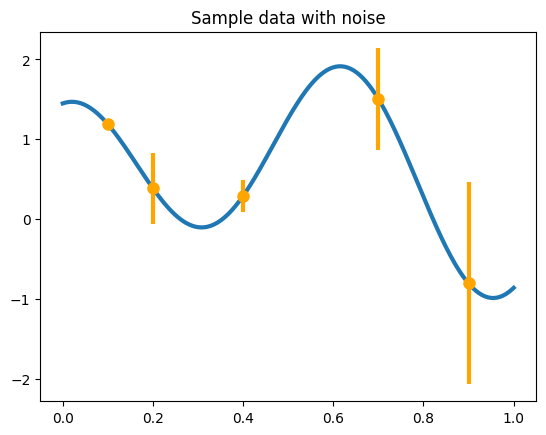

In [2]:
def yf(x):
    return np.cos(10 * x) * np.exp(.2 * x) + np.exp(-5 * (x - .4) ** 2)

xplt = np.linspace(0, 1, 300)
yplt = yf(xplt)

x = np.array([.1, .2, .4, .7, .9])
y = yf(x)
v = np.array([.001, .05, .01, .1, .4])

pyplot.plot(xplt, yplt, linewidth=lw)
pyplot.plot(x, y, 'o', markersize=ms, color='orange')
pyplot.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
pyplot.title('Sample data with noise');

## Computation of the qEI quantity using `qmcpy`

One quantity which can appear often during BO is a computation involving $q$ "next points" to sample in a BO process; in the standard formulation this quantity might involve just $q=1$, but $q>1$ is also of interest for batched evaluation in parallel.

This quantity is defined as
$$
\mathrm{EI}_q(x_1, \ldots, x_q;\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}) = \int_{\mathbb{R}^q} \max_{1\leq i\leq q}\left[{(y_i - y^*)_+}\right]\, p_{Y_{x_1,\ldots, x_q}|\mathbf{y}, \mathcal{X}, \boldsymbol{\epsilon}}(y_1, \ldots, y_q)\; \text{d}y_1\cdots\text{d}y_q
$$

The example we are considering here is with $q=5$ but this quantity could be made larger.  Each of these QEI computations (done in a vectorized fashion in production) would be needed in an optimization loop (likely powered by CMAES or some other high dimensional non-convex optimization tool).  This optimization problem would take place in a $qd$ dimensional space, which is one aspect which usually prevents $q$ from being too large.

Note that some of this will look much more confusing in $d>1$, but it is written here in a simplified version.

## GP model definition (kernel information) and qEI definition

In [3]:
shape_parameter = 4.1
process_variance = .9
fudge_factor = 1e-10

def gaussian_kernel(x, z):
    return process_variance * np.exp(-shape_parameter ** 2 * (x[:, None] - z[None, :]) ** 2)

def gp_posterior_params(x_to_draw):
    n = len(x_to_draw)
    
    kernel_prior_data = gaussian_kernel(x, x)
    kernel_cross_matrix = gaussian_kernel(x_to_draw, x)
    kernel_prior_plot = gaussian_kernel(x_to_draw, x_to_draw)
    prior_cholesky = np.linalg.cholesky(kernel_prior_data + np.diag(v))
    
    partial_cardinal_functions = solve_triangular(prior_cholesky, kernel_cross_matrix.T, lower=True)
    posterior_covariance = kernel_prior_plot - np.dot(partial_cardinal_functions.T, partial_cardinal_functions) + fudge_factor * np.eye(n)
    
    full_cardinal_functions = solve_triangular(prior_cholesky.T, partial_cardinal_functions, lower=False)
    posterior_mean = np.dot(full_cardinal_functions.T, y)
    return posterior_mean,posterior_covariance

def gp_posterior_draws(x_to_draw, mc_strat, num_posterior_draws, posterior_mean, posterior_covariance):
    q = len(x_to_draw)
    if mc_strat == 'iid':
        dd = IIDStdUniform(q)
    elif mc_strat == 'lattice':
        dd = Lattice(q)
    elif mc_strat == 'sobol':
        dd = Sobol(q)
    g = Gaussian(dd,posterior_mean,posterior_covariance)
    posterior_draws = g.gen_samples(num_posterior_draws)
    return posterior_draws

def compute_qei(posterior_draws):
    y_gp = np.fmax(np.max(posterior_draws.T - max(y), axis=0), 0)
    return y_gp

## Demonstrate the concept of qEI on 2 points

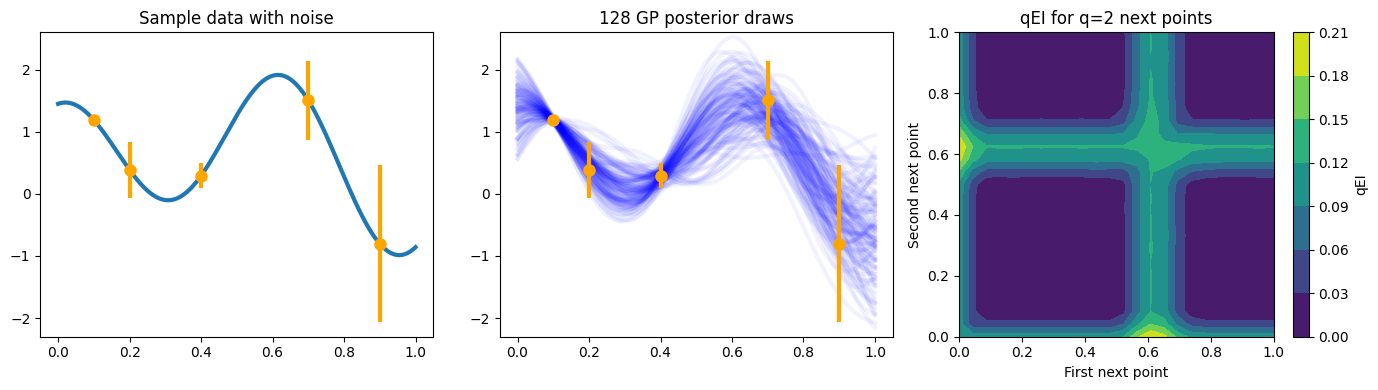

In [4]:
num_posterior_draws = 2 ** 7
Np = (25, 24)
X, Y = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X.reshape(-1), Y.reshape(-1)]).T
mu_post,sigma_cov = gp_posterior_params(xplt)
y_draws = gp_posterior_draws(xplt, 'lattice', num_posterior_draws,mu_post,sigma_cov).T
qei_vals = np.empty(len(xp))
for k, next_x in enumerate(xp):
    mu_post,sigma_cov = gp_posterior_params(next_x)
    gp_draws = gp_posterior_draws(next_x, 'sobol', num_posterior_draws,mu_post,sigma_cov)
    qei_vals[k] = compute_qei(gp_draws).mean()
Z = qei_vals.reshape(Np)

fig, axes = pyplot.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
ax.plot(xplt, yplt, linewidth=lw)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
ax.set_title('Sample data with noise')
ax.set_ylim((-2.3, 2.6))

ax = axes[1]
ax.plot(xplt, y_draws, linewidth=lw, color='b', alpha=.05)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
ax.set_title(f'{num_posterior_draws} GP posterior draws')
ax.set_ylim((-2.3, 2.6))

ax = axes[2]
h = ax.contourf(X, Y, Z)
ax.set_xlabel('First next point')
ax.set_ylabel('Second next point')
ax.set_title('qEI for q=2 next points')
cax = fig.colorbar(h, ax=ax)
cax.set_label('qEI')

fig.tight_layout()

## Choose some set of next points against which to test the computation

Here, we consider $q=5$, which is much more costly to compute than the $q=2$ demonstration above.

**Note** This will take some time to run.  Use fewer `num_repeats` to reduce the cost.

In [5]:
# parameters
next_x = np.array([0.158,  0.416,  0.718,  0.935,  0.465])
num_posterior_draws_to_test = 2 ** np.arange(4, 20)
d = len(next_x)
mu_post,sigma_cov = gp_posterior_params(next_x)

In [6]:
# get reference answer with qmcpy
integrand = CustomFun(
    true_measure = Gaussian(Sobol(d),mu_post,sigma_cov),
    g = compute_qei)
stopping_criterion = CubQMCSobolG(integrand, abs_tol=5e-7)
reference_answer,data = stopping_criterion.integrate()
print(data)

Data (Data)
    solution        0.024
    comb_bound_low  0.024
    comb_bound_high 0.024
    comb_bound_diff 8.33e-07
    comb_flags      1
    n_total         2^(22)
    n               2^(22)
    time_integrate  4.020
CubQMCNetG (AbstractStoppingCriterion)
    abs_tol         5.00e-07
    rel_tol         0
    n_init          2^(10)
    n_limit         2^(35)
CustomFun (AbstractIntegrand)
Gaussian (AbstractTrueMeasure)
    mean            [ 0.807  0.371  1.204 -0.455  0.67 ]
    covariance      [[ 1.845e-02 -2.039e-03  1.150e-04  1.219e-04 -5.985e-03]
                     [-2.039e-03  1.355e-02  6.999e-04 -1.967e-03  2.302e-02]
                     [ 1.150e-04  6.999e-04  8.871e-02  2.043e-02  5.757e-03]
                     [ 1.219e-04 -1.967e-03  2.043e-02  2.995e-01 -9.482e-03]
                     [-5.985e-03  2.302e-02  5.757e-03 -9.482e-03  6.296e-02]]
    decomp_type     PCA
DigitalNetB2 (AbstractLDDiscreteDistribution)
    d               5
    replications    1
    randomiz

In [7]:
# generate data
num_posterior_draws_to_test = 2 ** np.arange(4, 20)
vals = {}
num_repeats = 50
mc_strats = ('iid', 'lattice', 'sobol')
for mc_strat in mc_strats:
    vals[mc_strat] = []
    for num_posterior_draws in num_posterior_draws_to_test:
        all_estimates = []
        for _ in range(num_repeats):
            y_draws = gp_posterior_draws(next_x, mc_strat, num_posterior_draws,mu_post,sigma_cov)
            all_estimates.append(compute_qei(y_draws).mean())
        vals[mc_strat].append(all_estimates)
    vals[mc_strat] = np.array(vals[mc_strat])

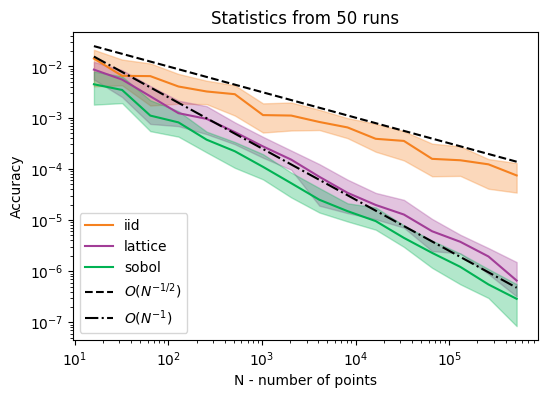

In [8]:
fig, ax = pyplot.subplots(1, 1, figsize=(6, 4))

colors = ('#F5811F', '#A23D97', '#00B253')
alpha = .3

for (name, results), color in zip(vals.items(), colors):
    bot = np.percentile(abs(results - reference_answer), 25, axis=1)
    med = np.percentile(abs(results - reference_answer), 50, axis=1)
    top = np.percentile(abs(results - reference_answer), 75, axis=1)
    ax.loglog(num_posterior_draws_to_test, med, label=name, color=color)
    ax.fill_between(num_posterior_draws_to_test, bot, top, color=color, alpha=alpha)
ax.loglog(num_posterior_draws_to_test, .1 * num_posterior_draws_to_test ** -.5, '--k', label='$O(N^{-1/2})$')
ax.loglog(num_posterior_draws_to_test, .25 * num_posterior_draws_to_test ** -1.0, '-.k', label='$O(N^{-1})$')
ax.set_xlabel('N - number of points')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower left')
ax.set_title(f'Statistics from {num_repeats} runs');

# plt.savefig('qei_convergence.png');

In [9]:
# parameters
names = ['IID','Lattice','Sobol']
epsilons = [
      [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2], # iid nodes
      [5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2], # lattice
      [5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]] # sobol
trials = 25
# initialize time data
times = {names[j]:np.zeros((len(epsilons[j]),trials),dtype=float) for j in range(len(names))}
n_needed = {names[j]:np.zeros((len(epsilons[j]),trials),dtype=float) for j in range(len(names))}
# run tests
for t in range(trials):
  print(t)
  for j in range(len(names)):
    for i in range(len(epsilons[j])): 
      if j == 0:
        sc = CubMCG(CustomFun(Gaussian(IIDStdUniform(d),mu_post,sigma_cov),compute_qei),abs_tol=epsilons[j][i],rel_tol=0)
      elif j == 1:
        sc = CubQMCLatticeG(CustomFun(Gaussian(Lattice(d),mu_post,sigma_cov),compute_qei),abs_tol=epsilons[j][i],rel_tol=0)
      else:
        sc = CubQMCSobolG(CustomFun(Gaussian(Sobol(d),mu_post,sigma_cov),compute_qei),abs_tol=epsilons[j][i],rel_tol=0)
      solution,data = sc.integrate()
      times[names[j]][i,t] = data.time_integrate
      n_needed[names[j]][i,t] = data.n_total

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


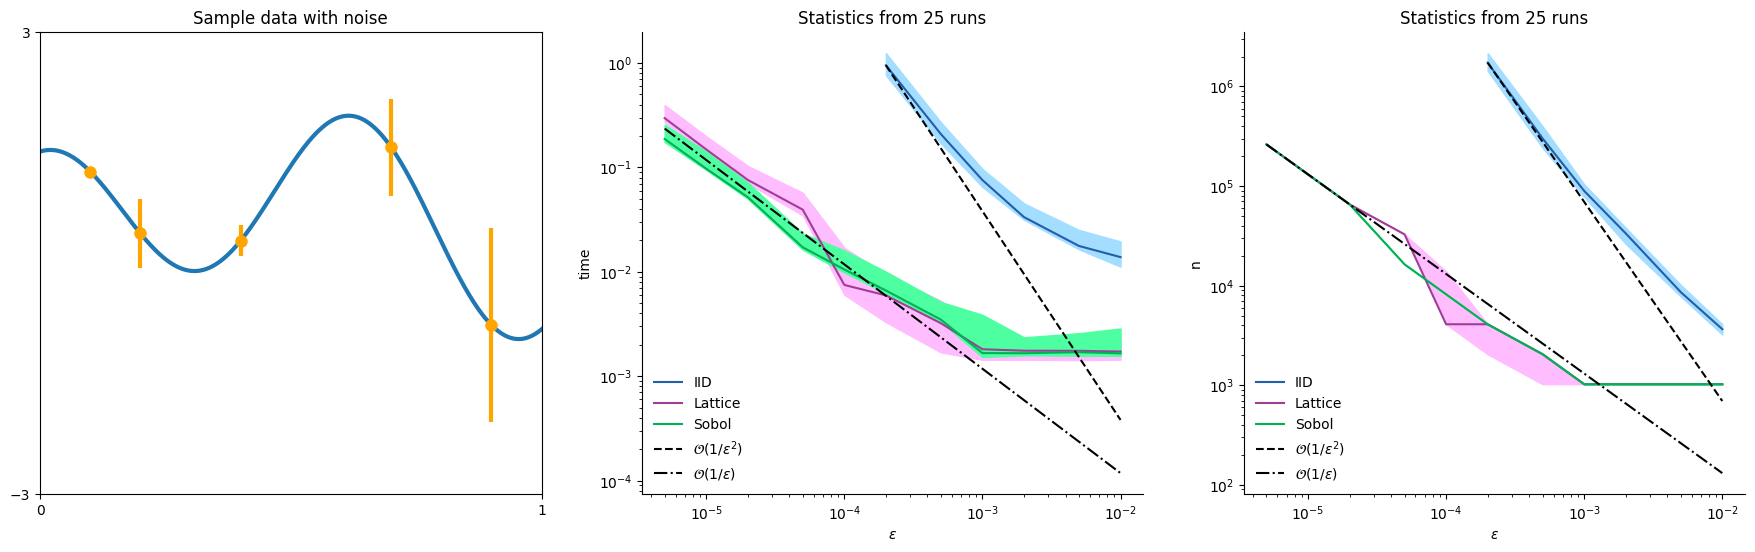

In [11]:
fig,axs = pyplot.subplots(1, 3, figsize=(22, 6))
colors = ('#245EAB', '#A23D97', '#00B253')
light_colors = ('#A3DDFF', '#FFBCFF', '#4DFFA0')
alpha = .3
def plot_fills(eps,data,name,color,light_color):
    bot = np.percentile(data, 5, axis=1)
    med = np.percentile(data, 50, axis=1)
    top = np.percentile(data, 95, axis=1)
    ax.loglog(eps, med, label=name, color=color)
    ax.fill_between(eps, bot, top, color=light_color)
    return med
for i,(nt_data,label) in enumerate(zip([times,n_needed],['time','n'])):
  ax = axs[i+1]
  # iid plot
  eps_iid = np.array(epsilons[0])
  data = nt_data['IID']
  med_iid = plot_fills(eps_iid,data,'IID',colors[0],light_colors[0])
  # lattice plot
  eps = np.array(epsilons[1])
  data = nt_data['Lattice']
  med_lattice = plot_fills(eps,data,'Lattice',colors[1],light_colors[1])
  # sobol plot
  eps = np.array(epsilons[2])
  data = nt_data['Sobol']
  med_sobol = plot_fills(eps,data,'Sobol',colors[2],light_colors[2])
  # iid bigO
  ax.loglog(eps_iid, (med_iid[0]*eps_iid[0]**2)/(eps_iid**2), '--k', label=r'$\mathcal{O}(1/\epsilon^2)$')
  # ld bigO
  ax.loglog(eps, ((med_lattice[0]*med_sobol[0])**.5 *eps[0]) / eps , '-.k', label=r'$\mathcal{O}(1/\epsilon)$')
  # metas
  ax.set_xlabel(r'$\epsilon$')
  ax.set_ylabel(label)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.legend(loc='lower left',frameon=False)
  ax.set_title(f'Statistics from {trials} runs')
# plot sample data
ax = axs[0]
ax.plot(xplt, yplt, linewidth=lw)
ax.plot(x, y, 'o', markersize=ms, color='orange')
ax.errorbar(x, y, yerr=2 * np.sqrt(v), marker='', linestyle='', color='orange', linewidth=lw)
ax.set_title('Sample data with noise')
ax.set_xlim([0,1])
ax.set_xticks([0,1])
ax.set_ylim([-3, 3])
ax.set_yticks([-3,3]);